In [1]:
import os
from tqdm import tqdm
import math
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score
from scipy import stats

from src.utils import parse_filename, normalize, sliding_window
from src.experiment import train_federated, create_model, train_central

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

from xstream.python.Chains import Chains

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

Load the data

In [2]:
data_name = "synth"

if data_name == "xdk" or data_name == "MHEALTHDATASET" or "pmsm_temperature_data":
    data = []
    directory = os.path.join(os.getcwd(), "data", data_name)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                print("Read {}".format(file))
                data.append(np.loadtxt(os.path.join(directory, file), skiprows=1, delimiter=","))
    data = np.array(data)
if data_name == "synth":
    data = np.load(os.path.join(os.getcwd(), "data", "synth", "10_10000_100_0.2_0.2_0.01_0.4_0.2_local_d.npy"))
    print("data is {}.format(data)")
    
print("Executing on {} data".format(data_name))

data is {}.format(data)
Executing on synth data


Prepare data

In [3]:
min_length = min([len(d) for d in data])
max_length = 10000
indices = np.random.choice(np.arange(min_length), min(min_length, max_length))
trimmed_data = np.array([d[indices] for d in data])
oldshape = trimmed_data.shape
oldshape

(10, 10000, 100)

In [4]:
def normalize_along_axis(data, axis):
    maxval = data.max(axis=axis, keepdims=True)
    minval = data.min(axis=axis, keepdims=True)
    data = (data-minval)/(maxval-minval)
    return data

In [5]:
trimmed_data = normalize_along_axis(trimmed_data, axis=(0, 1))

Approximated contamination with outliers

In [6]:
contamination = 0.01
percentile = (1-contamination)*100
percentile

99.0

Global setting

In [7]:
trimmed_data = np.reshape(trimmed_data, newshape=(trimmed_data.shape[0]*trimmed_data.shape[1], trimmed_data.shape[2]))
model = create_model(trimmed_data.shape[-1], 0.4)
model.fit(trimmed_data, trimmed_data,
          batch_size=32, 
          epochs=10, shuffle=True)

Train on 100000 samples
Epoch 1/10
100000/100000 [==============================] - 8s 84us/sample - loss: 0.7175
Epoch 2/10
100000/100000 [==============================] - 8s 80us/sample - loss: 0.6947
Epoch 3/10
100000/100000 [==============================] - 8s 78us/sample - loss: 0.6947
Epoch 4/10
100000/100000 [==============================] - 8s 81us/sample - loss: 0.6948
Epoch 5/10
100000/100000 [==============================] - 8s 75us/sample - loss: 0.6947
Epoch 6/10
100000/100000 [==============================] - 8s 78us/sample - loss: 0.6947
Epoch 7/10
100000/100000 [==============================] - 8s 81us/sample - loss: 0.6947
Epoch 8/10
100000/100000 [==============================] - 8s 79us/sample - loss: 0.6947
Epoch 9/10
100000/100000 [==============================] - 9s 89us/sample - loss: 0.6948
Epoch 10/10
100000/100000 [==============================] - 9s 89us/sample - loss: 0.6948


In [8]:
predicted = model.predict(trimmed_data)
diff = predicted - trimmed_data
dist = np.linalg.norm(diff, axis=-1)

In [9]:
labels_global = dist > np.percentile(dist, percentile)

Local setting

In [10]:
trimmed_data = np.reshape(trimmed_data, newshape=(oldshape[0], oldshape[1], trimmed_data.shape[-1]))
models = [create_model(trimmed_data.shape[-1], 0.4) for i in range(len(trimmed_data))]
[m.fit(trimmed_data[i], trimmed_data[i],
       batch_size=32, 
       epochs=10, shuffle=True) for i, m in enumerate(models)]

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 166us/sample - loss: 0.8970
Epoch 2/10
10000/10000 [==============================] - 1s 100us/sample - loss: 0.6621
Epoch 3/10
10000/10000 [==============================] - 1s 113us/sample - loss: 0.6571
Epoch 4/10
10000/10000 [==============================] - 1s 118us/sample - loss: 0.6546
Epoch 5/10
10000/10000 [==============================] - 1s 114us/sample - loss: 0.6534
Epoch 6/10
10000/10000 [==============================] - 1s 102us/sample - loss: 0.6529
Epoch 7/10
10000/10000 [==============================] - 1s 103us/sample - loss: 0.6527
Epoch 8/10
10000/10000 [==============================] - 1s 100us/sample - loss: 0.6526
Epoch 9/10
10000/10000 [==============================] - 1s 101us/sample - loss: 0.6526
Epoch 10/10
10000/10000 [==============================] - 1s 104us/sample - loss: 0.6526
Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 18

In [11]:
predictions_local = np.array([m.predict(trimmed_data[i]) for i, m in enumerate(models)])

In [12]:
diff_local = predictions_local - np.reshape(trimmed_data, predictions_local.shape)
dist_local = np.linalg.norm(diff_local, axis=-1)

In [13]:
result_local = dist_local
result_global = dist

In [14]:
outlier_thresh_local = np.percentile(result_local, percentile, axis=1, keepdims=True)
outlier_thresh_local = np.repeat(outlier_thresh_local, result_local.shape[-1], axis=-1)
labels_local = (result_local > outlier_thresh_local).flatten()
outlier_thresh_local.shape

(10, 10000)

In [15]:
outlier_thresh_global = np.percentile(result_global, q=percentile)
labels_global = (result_global > outlier_thresh_global).flatten()
np.sum(labels_global)

1000

In [16]:
result_local = np.reshape(result_local, newshape=result_global.shape)

In [21]:
print(np.sum(labels_global))
print(np.sum(labels_local))

print("The fraction of local outliers for {} is {}".format(
    data_name, 
    1 - np.sum(np.logical_and(labels_global.flatten(), labels_local))/np.sum(labels_local)
))

1000
993
The fraction of local outliers for synth is 0.9657603222557906


Text(0.5, 0, 'Outlier scores by $C$')

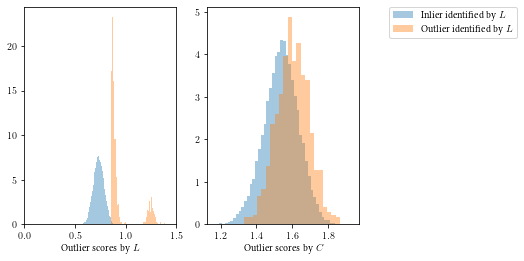

In [18]:
fig, axes = plt.subplots(1, 2, sharey=False)

ax = axes[0]
sns.distplot(result_local[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.3}, norm_hist=True, 
             ax=ax)

sns.distplot(result_local[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True, 
             ax=ax)

ax.set_xlim((0, 1.5))
ax.set_xlabel("Outlier scores by $L$")

ax = axes[1]

sns.distplot(result_global[np.invert(labels_local.flatten())], 
             hist=True, rug=False, kde=False, norm_hist=True, 
             rug_kws={"alpha": 0.3}, label="Inlier identified by $L$", 
             ax=ax)

sns.distplot(result_global[labels_local.flatten()], 
             hist=True, rug=False, kde=False, 
             rug_kws={"alpha": 0.5}, norm_hist=True, 
             label="Outlier identified by $L$", 
             ax=ax)


# ax.set_xlim((0, 1.5))
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

ax.set_xlabel("Outlier scores by $C$")
# plt.tight_layout()

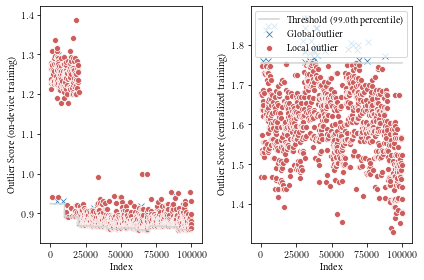

In [19]:
x = np.array([i for i in range(len(result_global))])

# labels_local and not labels_global
is_local_outlier = np.logical_and(labels_local, result_global < np.percentile(result_global, percentile))
is_global_outlier = np.logical_and(np.invert(is_local_outlier), labels_local)

plt.subplot(121)

sns.lineplot(x, outlier_thresh_local.flatten(), 
                 alpha=1, color="lightgrey")
sns.scatterplot(x[is_global_outlier], result_local[is_global_outlier], 
                alpha=1.0, marker="x")
sns.scatterplot(x[is_local_outlier], result_local[is_local_outlier], 
                color="indianred")

plt.xlabel("Index")
plt.ylabel("Outlier Score (on-device training)")

ax = plt.subplot(122)

sns.lineplot(x, outlier_thresh_global, 
                 alpha=1, color="lightgrey", label="Threshold ({}th percentile)".format(percentile))
sns.scatterplot(x[is_global_outlier], result_global[is_global_outlier], 
                alpha=1.0, marker="x", label="Global outlier")
sns.scatterplot(x[is_local_outlier], result_global[is_local_outlier], 
                color="indianred", alpha=1.0, label="Local outlier")

plt.legend(loc="upper right")
plt.xlabel("Index")
plt.ylabel("Outlier Score (centralized training)")

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", "results", "xdk_comparison_local_central_ae.pdf"))
plt.show()